In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score,roc_auc_score,precision_recall_curve,\
f1_score,roc_curve,mean_squared_error,mean_absolute_error
from tqdm import * 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Train data

## Cancer

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
cancer_data = load_breast_cancer()

In [4]:
print(cancer_data['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [5]:
cancer_Y = cancer_data['target']
cancer_X = cancer_data['data']

In [6]:
scaler = StandardScaler()
norm = MinMaxScaler()

In [7]:
board = round(0.8*len(cancer_Y))

In [8]:
norm_cancer_X = norm.fit_transform(cancer_X)

In [9]:
enc = OneHotEncoder()
cat_cancer_Y = enc.fit_transform(cancer_Y.reshape(-1,1)).toarray()

In [10]:
cancer_X_train = norm_cancer_X[:board]
cancer_X_test = norm_cancer_X[:-board]
cancer_Y_train = cat_cancer_Y[:board]
cancer_Y_test = cat_cancer_Y[:-board]

## Boston

In [11]:
from sklearn.datasets import load_boston

In [12]:
boston_data = load_boston()

In [13]:
print(boston_data['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [14]:
boston_X = boston_data['data']
boston_Y = boston_data['target']
yscaler = MinMaxScaler()
xscaler = MinMaxScaler()
norm_boston_Y = yscaler.fit_transform(boston_Y.reshape(-1,1))
norm_boston_X = xscaler.fit_transform(boston_X)

In [15]:
#we use this function to create multi-class target from regression target
def categorical_encoder(Y):
    enc_y = []
    for a in Y:
        if a > 0.5:
            enc_y.append([0,1])
        else:
            enc_y.append([1,0])
    return np.array(enc_y)

In [16]:
boston_cat_class = categorical_encoder(norm_boston_Y)

In [17]:
board = round(0.9*len(boston_cat_class))

In [18]:
norm_boston_X_train = norm_boston_X[:board]
norm_boston_X_test = norm_boston_X[board:]
norm_boston_Y_train = norm_boston_Y[:board].reshape(-1,1)
norm_boston_Y_test = norm_boston_Y[board:].reshape(-1,1)
boston_Y_train = boston_Y[:board].reshape(-1,1)#we use this data
boston_Y_test = boston_Y[board:].reshape(-1,1)#we use this data
boston_cat_class_train = boston_cat_class[:board]
boston_cat_class_test = boston_cat_class[board:]

# Neural Network

## Basis

In [20]:
def softmax(x, deriv = False):
    return np.array([it * (1 - it) for it in x])  if deriv else np.array([np.exp(it) / np.sum(np.exp(it)) for it in x])

In [21]:
def sigmoid(x, deriv = False):
    return x*(1-x) if deriv else 1/(1+np.exp(-x))

In [22]:
def linear(x, deriv = False):
    return np.ones(x.shape) if deriv else x    

In [23]:
def cross_entropy(y,q):
    return -y*np.log2(q)+(1-y)*np.log2(1-q)

In [24]:
class Init_layer:
    def __init__(self,n):
        self.n = n
    def get_data(self,x):
        if self.n != x.shape[1]:
            raise ValueError(f'invalid train data dimension: requered (_,{self.n}), received {x.shape}')
        self.layer = x
    def backward(self,*args):
        pass
    def forvard(self,*args):
        pass
    def update_weights(self, *args):
        pass

In [25]:
class Layer:
    def __init__(self,n,f,prev_layer):
        self.n = n
        self.prev_layer = prev_layer
        self.syn = 2*np.random.random((prev_layer.n,n)) - 1  #syn - связи с предыдущим слоем
        self.f_activ = f
    
    def forvard(self):
        self.prev_layer.forvard()
        self.layer = self.f_activ(self.prev_layer.layer.dot(self.syn))
                
        
    def backward(self,follow_layer):
        self.error = follow_layer.gradient.dot(follow_layer.syn.T)
        self.gradient = self.error*self.f_activ(self.layer, deriv = True)
        self.prev_layer.backward(self)
        
    def update_weights(self, lr):
        self.prev_layer.update_weights(lr)
        self.syn -= lr*self.prev_layer.layer.T.dot(self.gradient)

In [26]:
class Output_Layer(Layer):
    def __init__(self,n,f,prev_layer):
        super().__init__(n,f,prev_layer)
           
    def backward(self,y):
        self.error = self.layer - y
        self.gradient = self.error*self.f_activ(self.layer, deriv = True)
        self.prev_layer.backward(self)    

## Simple model

In [27]:
class Model:
    def __init__(self, input_layer, output_layer):
        self.input_layer = input_layer
        self.output_layer = output_layer
        
    def compile_model(self, epohs, lr = 1, loss = 'MSE', metrics = False, plots = False, loss_monitor = False):
        self.loss = loss
        self.epohs = epohs
        self.lr = lr
        self.metrics = metrics
        if metrics:
            self.metrics = dict.fromkeys(metrics)
            for i in self.metrics.keys():
                self.metrics[i] = []
        self.plots = plots
        self.loss_monitor = loss_monitor
        
        
    def train(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        lr = self.lr
        errors = []
        self.input_layer.get_data(self.X)   
        for j in range(self.epohs):
            self.output_layer.forvard()
            self.output_layer.backward(self.y)
            self.output_layer.update_weights(lr)
            
            #losses and metrics
            if self.loss == 'cross-entropy':
                errors.append(np.mean(abs(cross_entropy(self.y,self.output_layer.layer))))
            elif self.loss == 'MSE':
                errors.append(np.mean(self.output_layer.error**2))
            if self.metrics:    
                for i in self.metrics.keys():
                    self.metrics[i].append(eval(i+'(y.ravel(),np.round(self.output_layer.layer).ravel())'))  
                
            if self.loss_monitor:   
                if (j% round(self.epohs/int(self.loss_monitor))) == 0:      
                    print('Loss: ', errors[j])
                    print('#')
        
        #plots
        if self.plots:            
            plt.plot(errors)
            plt.xlabel('loss', fontsize = 15)
            if self.metrics:
                fig, ax = plt.subplots(len(self.metrics), 1, figsize = (10, 10))
                for axnum, key in enumerate(self.metrics.keys()):
                    ax = fig.axes[axnum]
                    ax.plot(self.metrics.get(key))
                    ax.grid()
                    ax.set_title(str(key),fontsize = 15)           
        plt.show()

        
    def predict(self,x):
        x = np.array(x)
        self.input_layer.get_data(x)
        self.output_layer.forvard()
        return np.squeeze(np.round(self.output_layer.layer).astype(int))

In [28]:
def evaluate_сlass(y_real, y_pred, plot = False):
    y_pred = y_pred.ravel()
    y_real = y_real.ravel()
    accurasy = accuracy_score(y_real,y_pred)
    roc_auc = roc_auc_score(y_real,y_pred)
    f1 = f1_score(y_real,y_pred)
    if plot:
        precision, recall, _ = precision_recall_curve(y_real,y_pred)
        fpr, tpr, threshold = roc_curve(y_real,y_pred)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
        ax1.plot(fpr,tpr)
        ax1.set_title('roc-auc',fontsize = 16)
        ax1.set_xlabel('f p r', fontsize = 15)
        ax1.set_ylabel('t p r', fontsize = 15)
        ax2.plot(recall,precision)
        ax2.set_title('precision-recall',fontsize = 16)
        ax2.set_xlabel('recall', fontsize = 15)
        ax2.set_ylabel('precision', fontsize = 15)
        plt.show()
    return {'accurasy':accurasy,'roc_auc':roc_auc, 'f1':f1 }

## Multi-model for NN with several outputs

In [29]:
class Multi_Model:
    def __init__(self, input_layer, output_layers):
        self.input_layer = input_layer
        self.output_layers = output_layers
        
    def compile_model(self, epohs, losses, lr = [1],  
                      metrics = False, plots = False, loss_monitor = False):       
        self.epohs = epohs
        if (len(lr) != len(self.output_layers)) & (len(lr) != 1 ):
            raise ValueError('not enough values: number of learning raites must be equal output layers number')
        self.lr = lr
        if (len(losses) != len(self.output_layers)) & (len(losses) != 1 ):
            raise ValueError('not enough values: number of loss-f must be equal output layers number')
        self.losses = dict.fromkeys(losses)
        for j in self.losses.keys():
            self.losses[j] = []
        self.metrics = metrics
        if metrics:
            self.metrics = []
            for i in range(len(metrics)):
                self.metrics.append(dict.fromkeys(metrics[i]))
                for j in self.metrics[i].keys():
                    self.metrics[i][j] = []
        self.plots = plots
        self.loss_monitor = loss_monitor
        
        
    def train(self, X, y):
        self.X = np.array(X)
        self.y = y
        self.input_layer.get_data(self.X)   
        for j in range(self.epohs):
            for num, output_layer in enumerate(self.output_layers): 
                self.y[num] = np.array(self.y[num])
                output_layer.forvard()
                output_layer.backward(self.y[num])
                output_layer.update_weights(self.lr[num]) 
                
                #losses and metrics          
                for i, key in enumerate(self.losses.keys()):
                    if i == num:
                        if key == 'cross-entropy':
                            self.losses[key].append(np.mean(abs(cross_entropy(self.y[num],output_layer.layer))))
                        elif key == 'MSE':
                            self.losses[key].append(np.mean(output_layer.error**2))           
                if self.metrics:    
                    for i in self.metrics[num].keys():
                        self.metrics[num][i].append(eval(i+'(self.y[num].ravel(),np.round(output_layer.layer).ravel())'))                           
            if self.loss_monitor:   
                if (j% round(self.epohs/int(self.loss_monitor))) == 0: 
                    for key in self.losses.keys():
                        print(key+' loss: ', self.losses[key][j])
                    print('#')
        
        if self.plots:
            self.plot_results() 
            
    #plots
    def plot_results(self, figsize = (10,10)):
        fig, ax = plt.subplots(len(self.losses), 1, figsize = figsize)
        for axnum, key in enumerate(self.losses.keys()):
            ax = fig.axes[axnum]
            ax.plot(self.losses.get(key))
            ax.grid()
            ax.set_title('Out '+str(axnum)+': '+key+' loss',fontsize = 15) 
        if self.metrics:
            for i in range(len(self.metrics)):  
                fig, ax = plt.subplots(len(self.metrics[i]), 1, figsize = figsize)
                for axnum, key in enumerate(self.metrics[i].keys()):
                    ax = fig.axes[axnum]
                    ax.plot(self.metrics[i].get(key))
                    ax.grid()
                    ax.set_title('Out '+str(i)+': '+key,fontsize = 15) 
        plt.show()
 

    def predict(self,x):
        x = np.array(x)
        predict = []
        self.input_layer.get_data(x)
        for output_layer in self.output_layers:
            output_layer.forvard()
            predict.append(output_layer.layer)
        #return np.squeeze(np.round(self.output_layer.layer).astype(int))
        return predict

# TRAIN and validation

In [30]:
#for the same weights at each start
np.random.seed(17)

# Simple classification model

In [31]:
#Very simple data for tests
#x = np.array([[0,0,1],[0,0,0],[1,1,1],[1,1,0]])
#y = np.array([[1,0],[1,0],[0,1],[0,1]])

In [32]:
#classifier architecture
l0 = Init_layer(cancer_X_train.shape[1])
l1 = Layer(8,sigmoid,l0)
l2 = Layer(4,sigmoid,l1)
l3 = Output_Layer(2,softmax,l2) 

In [33]:
model = Model(l0,l3)

In [34]:
#metrics=['accuracy_score','f1_score']
model.compile_model(1000, lr = 0.01,loss = 'cross-entropy',
                    metrics=['accuracy_score','f1_score'], plots = True, loss_monitor = 10)

Loss:  1.0525230484447805
#
Loss:  0.3181748060465205
#
Loss:  0.19606920625150617
#
Loss:  0.15468710417793016
#
Loss:  0.13278078928765452
#
Loss:  0.1193751436904772
#
Loss:  0.11031952007489816
#
Loss:  0.10363664494806872
#
Loss:  0.09823730850197564
#
Loss:  0.09338738876464252
#


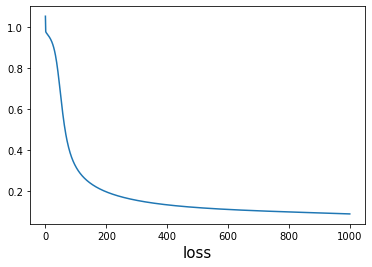

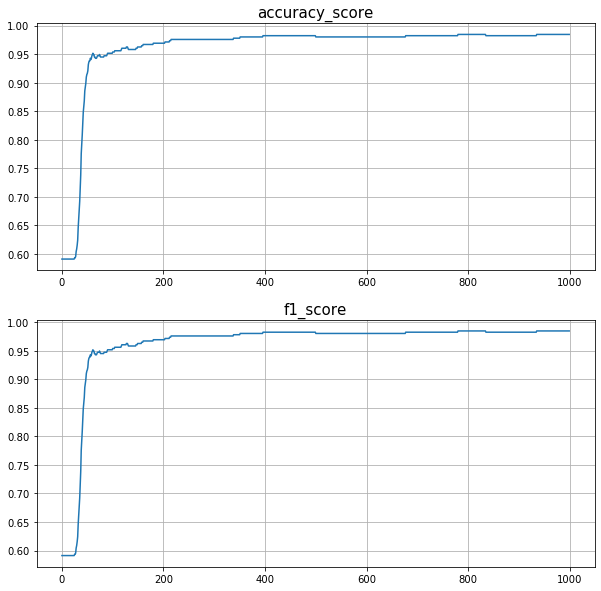

In [35]:
model.train(cancer_X_train,cancer_Y_train)

In [36]:
cancer_Y_pred = model.predict(cancer_X_test)

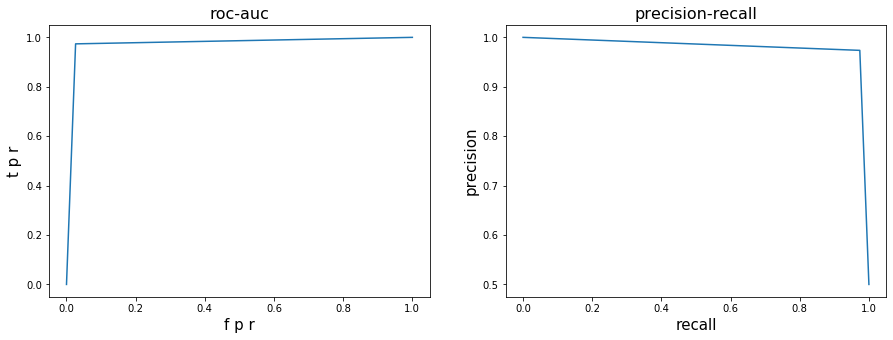

{'accurasy': 0.9736842105263158,
 'f1': 0.9736842105263158,
 'roc_auc': 0.9736842105263158}

In [37]:
evaluate_сlass(cancer_Y_test.ravel(), cancer_Y_pred.ravel(), plot = True)

# Two-outputs regression-classifier multi-model

In [38]:
np.random.seed(1)

In [39]:
l0 = Init_layer(norm_boston_X_train.shape[1])
l1 = Layer(8,sigmoid,l0)
l2_1 = Layer(2,sigmoid,l1)
l2_2 = Layer(3,sigmoid,l1)
l3_1 = Output_Layer(1,linear,l2_1)
l3_2 = Output_Layer(2,softmax,l2_2)

In [40]:
l0.n,l1.n,(l2_1.n,l2_2.n),(l3_1.n,l3_2.n)

(13, 8, (2, 3), (1, 2))

In [41]:
multi_model = Multi_Model(l0,[l3_1,l3_2])

In [42]:
losses = ['MSE','cross-entropy'] 
metrics = [['mean_absolute_error'],['accuracy_score','f1_score']]

In [43]:
multi_model.compile_model(10000, lr = [0.0001,0.0001], losses = losses, metrics = metrics, plots = False, loss_monitor = 10)

In [44]:
multi_model.train(norm_boston_X_train,[boston_Y_train,boston_cat_class_train])

MSE loss:  662.9690761597903
cross-entropy loss:  1.1948299453810136
#
MSE loss:  12.916271127103347
cross-entropy loss:  0.7882263277654021
#
MSE loss:  8.181864092466908
cross-entropy loss:  0.7310864642444356
#
MSE loss:  6.698634389946774
cross-entropy loss:  0.6121079465722754
#
MSE loss:  6.149963130415301
cross-entropy loss:  0.5416756735744401
#
MSE loss:  5.747996047539247
cross-entropy loss:  0.48936141992288074
#
MSE loss:  5.427064473918604
cross-entropy loss:  0.4434127247120431
#
MSE loss:  5.173878217842192
cross-entropy loss:  0.4047402880516897
#
MSE loss:  4.946669155666304
cross-entropy loss:  0.37414776014322393
#
MSE loss:  4.756472934228224
cross-entropy loss:  0.34978567443364156
#


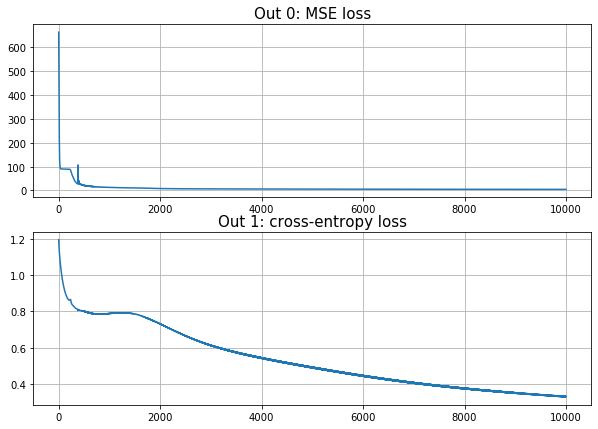

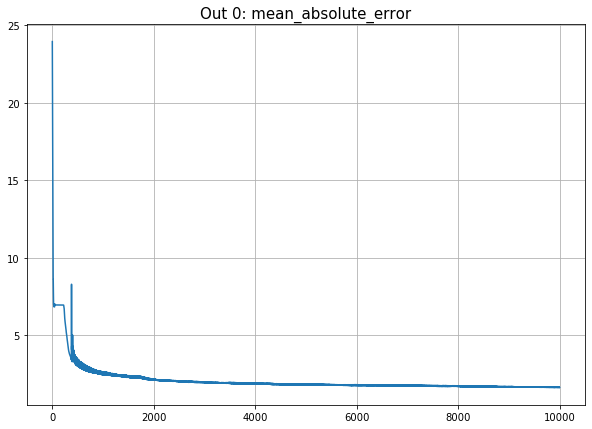

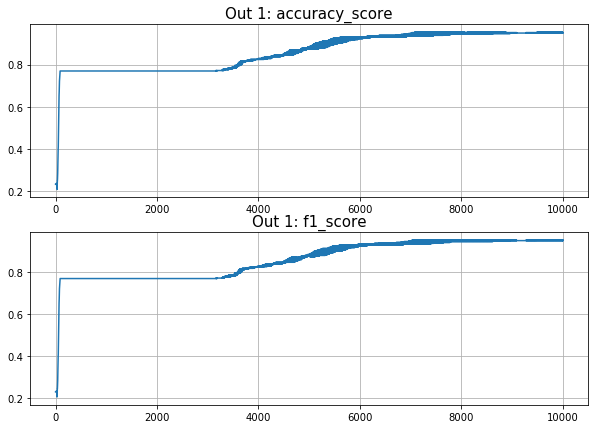

In [45]:
multi_model.plot_results((10,7))

In [46]:
pred_Y, pred_C = multi_model.predict(norm_boston_X_test)

In [47]:
boston_Y_test[:5]

array([[14.1],
       [12.7],
       [13.5],
       [14.9],
       [20. ]])

In [48]:
pred_Y[:5]

array([[12.70929107],
       [11.58379996],
       [11.41949751],
       [16.41495682],
       [16.29866067]])

In [49]:
1-mean_absolute_error(yscaler.transform(boston_Y_test),yscaler.transform(pred_Y))

0.9192708947831891

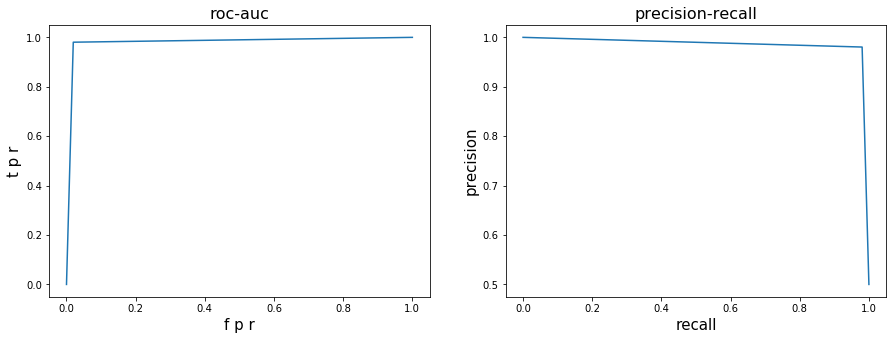

{'accurasy': 0.9803921568627451,
 'f1': 0.9803921568627451,
 'roc_auc': 0.9803921568627451}

In [50]:
evaluate_сlass(np.squeeze(boston_cat_class_test), np.squeeze(np.round(pred_C)), plot = True)

In [51]:
multi_model.losses

{'MSE': [662.9690761597903,
  622.2141082555564,
  598.1728374370537,
  571.0648803217196,
  535.0865557899409,
  495.2855974017273,
  456.10673789533524,
  417.3601555688884,
  376.90863356338224,
  333.8654458922051,
  292.713838480094,
  257.5706834246407,
  228.4340998374422,
  204.3638883429841,
  184.48639263791344,
  168.07064611535344,
  154.5125447656848,
  143.31367367962108,
  134.062829255805,
  126.42067938203657,
  120.10713445291171,
  114.89095881179408,
  110.58121989817417,
  107.02024458471982,
  104.07781323068605,
  101.64637150882153,
  99.63708005405361,
  97.97655437145751,
  96.60417378522631,
  95.46985971749693,
  94.5322411949789,
  93.75713993019262,
  93.1163191989827,
  92.58645050700666,
  92.14826008498072,
  91.78582388418283,
  91.4859852117813,
  91.23787365591353,
  91.03250767194642,
  90.86246627270178,
  90.7216178006869,
  90.60489585341963,
  90.50811416111834,
  90.42781364308944,
  90.3611360476489,
  90.3057195537193,
  90.25961251612391,
  

In [52]:
multi_model.metrics

[{'mean_absolute_error': [23.96043956043956,
   22.96043956043956,
   22.96043956043956,
   21.96043956043956,
   20.96043956043956,
   19.96043956043956,
   18.96043956043956,
   17.96043956043956,
   16.970989010989012,
   15.952087912087913,
   14.089670329670328,
   13.176263736263738,
   12.294945054945057,
   11.450109890109891,
   10.64043956043956,
   9.895824175824176,
   9.227692307692308,
   8.63076923076923,
   8.63076923076923,
   8.093626373626373,
   8.085274725274726,
   7.625934065934066,
   7.625934065934066,
   7.247032967032968,
   7.247032967032968,
   6.991208791208791,
   6.989010989010989,
   6.989010989010989,
   6.989010989010989,
   6.862857142857144,
   6.862857142857144,
   6.862857142857144,
   6.862857142857144,
   6.862857142857144,
   6.911208791208792,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.848351648351648,
   6.